# Recherche d'information dans la littérature scientifique

**MOD 7.2 (Introduction à la sciences des données)**, BE séances 4, 5, 6

**Enseignants :** Julien Velcin (CM, BE), Erwan Versmée (BE)

Le projet qu'on vous demande de réaliser est un **moteur de recherche** qui, étant donnée une publication, retourne les articles qui en sont le plus proche sémantiquement.
Pour simplifier le problème, pour une **requête donnée** (*query*), càd un article, on vous fournit 5 articles cités par celui-ci (les exemples positifs) et environ 25 articles choisis aléatoirement dans la base (les exemples négatifs).

La tâche consiste alors à construire un algorithme capable de **retourner les 5 citations et écarter les autres**.

Notez, qu'en plus du titre, d'**autres informations** susceptibles d'être utiles vous sont fournies : court résumé textuel, auteur(s) de l’article, année de publication, références bibliographiques, quels autres articles le citent.

**Exemple :**

Titre de l'article ciblé (notre requête, pour simplifier) : *"Bearish-Bullish Sentiment Analysis on Financial Microblogs"*

Quelques exemples positifs :

> "SemEval-2015 Task 11: Sentiment Analysis of Figurative Language in Twitter"
>
> "Text mining of news-headlines for FOREX market prediction: A Multi-layer Dimension Reduction Algorithm with semantics and sentiment"

Quelques exemples négatifs :

> "Analysis and Design of Average Current Mode Control Using a Describing-Function-Based Equivalent Circuit Model"
>
> "MVOR: A Multi-view RGB-D Operating Room Dataset for 2D and 3D Human Pose Estimation"


Votre moteur se basera sur un système *S* qui doit mesurer à quel point un article candidat *c* répond bien à la requête *q* à l'aide d'un **score d'appariement** S(q,c) : plus ce score est élevé, mieux l'article correspond à la requête.

Si *q* est la requête et *C* l'ensemble des candidats (environ 25 pour chaque requête), composés d'exemples positifs *C+* et négatifs *C-*, alors il faut que *S* retourne préférentiellement les exemples de *C+*, donc leur attribue un score important.


## Setup and Import Libraries

Ici se trouvent un certain nombre de librairies dont vous pourriez avoir besoin. Néanmoins, rien ne vous oblige à tout utiliser et vous pouvez ajouter vos propres librairies. Il est cependant important qu'il soit possible pour une tierce personne d'installer le nécessaire pour exécuter votre code.

In [1]:
import json
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# For embeddings and similarity computation
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install with: pip install sentence-transformers scikit-learn networkx")

np.random.seed(42)

Missing library: cannot import name 'PreTrainedModel' from 'transformers' (C:\Users\Jean Michel Girard\anaconda3\lib\site-packages\transformers\__init__.py)
Please install with: pip install sentence-transformers scikit-learn networkx


Le code qui suit peut être utile pour réaliser des affichages à partir de la matrice Documents x Termes, libre à vous de l'utiliser.

In [2]:
from scipy.sparse import find, csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import norm
from IPython.core.display import HTML

# des options permettent de limiter (ou non) le nombre de lignes/colonnes affichées
# par exemple :
# pd.set_option('display.max_rows', None)

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})   

# fonction qui permet d'afficher plusieurs tables pandas côte à côte (c'est cadeau)
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "&emsp;"
        #output += "\xa0\xa0\xa0"
    display(HTML(output))

## 1. Chargement et prise en main des données

La première étape consiste bien entendu à charger les données en mémoire et aller voir comment celles-ci sont structurées. On vous fournit 3 fichiers pour commencer :

- *corpus.jsonl* : le corpus lui-même, composé de plus de 25k articles scientifiques
- *queries.jsonl* : l'ensemble des documents qui constituent les requêtes qui seront adressées à notre moteur. Ces documents proviennent du corpus, mais il peut s'agir de documents qui ne sont que cités ou citent d'autres documents et pour lesquels on n'a que très peu d'information.
- *valid.tsv* : l'ensemble des données nécessaires pour entraîner et/ou tester votre moteur

Voilà un extrait du fichier *corpus.jsonl* :

![corpus](./corpus.jpg "Title")

Voilà un extrait du fichier *queries.jsonl* :

![corpus](./queries.jpg "Title")

Voilà un extrait du fichier *valid.tsv* :

![corpus](./test.jpg "Title")

Par la suite, on vous fournira à priori un 4ème fichier (*test_final.tsv*) qui contiendra des nouvelles données sur lesquelles vous pourrez réaliser  des prédictions. Les identifiants des candidats sont toujours tirés de votre corpus d'articles.

Nous vous conseillons d'employer la libraire *json* pour charger les données des deux premiers fichiers et utiliser des dictionnaires afin de pouvoir accéder aux articles via leurs identifiants. Pour rappel, un fichier *jsonl* n'est rien d'autre qu'un fichier dans lequel chaque ligne est composé d'un objet json bien formaté.

In [7]:
from collections import defaultdict
from typing import Dict

def load_corpus(file_path: str) -> Dict[str, Dict]:
    corpus = {}
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                doc_data = json.loads(line)
                doc_id = doc_data['_id']
                if doc_id:
                    corpus[doc_id] = doc_data
    except FileNotFoundError:
        print(f"Erreur: Le fichier {file_path} n'a pas été trouvé. Assurez-vous que les données sont au bon endroit.")
    except json.JSONDecodeError as e:
        print(f"Erreur de décodage JSON dans {file_path}: {e}")
    except Exception as e:
        print(f"Une erreur inattendue est survenue lors du chargement de {file_path}: {e}")
        
    return corpus

def load_queries(file_path: str) -> Dict[str, Dict]:
    queries = {}
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                query_data = json.loads(line)
                # La clé de la requête est '_id'
                query_id = query_data['_id']
                queries[query_id] = query_data
    except FileNotFoundError:
        print(f"Erreur: Le fichier {file_path} n'a pas été trouvé.")
    except json.JSONDecodeError as e:
        print(f"Erreur de décodage JSON dans {file_path}: {e}")

    return queries

def load_qrels(file_path: str) -> Dict[str, Dict[str, int]]:

    qrels = defaultdict(dict)
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            header = f.readline() 
            
            for line in f:
                parts = line.strip().split('\t')
                
                if len(parts) == 3:
                    query_id, candidate_id, score_str = parts
                    score = int(score_str)
                    
                    qrels[query_id][candidate_id] = score
    except FileNotFoundError:
        print(f"Erreur: Le fichier {file_path} n'a pas été trouvé.")
    except Exception as e:
        print(f"Erreur lors du traitement de {file_path}: {e}")
        
    return dict(qrels)

In [8]:
# Load the dataset
print("Loading dataset...")
corpus = load_corpus('corpus.jsonl')
queries = load_queries('queries.jsonl')
qrels_valid = load_qrels('valid.tsv')


print(f"Loaded {len(corpus)} documents in corpus")
print(f"Loaded {len(queries)} queries")
print(f"Loaded relevance for {len(qrels_valid)} queries (dataset)")

Loading dataset...
Loaded 25657 documents in corpus
Loaded 1000 queries
Loaded relevance for 700 queries (dataset)


## 2. Exploration des données et premier encodage

A présent, on vous propose de réaliser un certain nombre d'opérations pour mieux connaître vos données. Tout d'abord, il s'agit de calculer des statistiques simples telles que :

- Taille du corpus et du nombre de requêtes
- Nombre de paires requête / document
- Proportions de documents pertinents (non pertinents) par requête

Affichez ensuite un exemple de requête (vous pouvez vous limiter au titre de l'article), accompagnée d'exemples de candidats positifs et de candidats négatifs.

In [5]:
nb_corpus = len(corpus)
nb_queries = len(queries)

total_pairs = sum(len(candidates) for candidates in qrels_valid.values())

total_relevant = 0
total_non_relevant = 0

for qid, candidates in qrels_valid.items():
    for score in candidates.values():
        if score == 1:
            total_relevant += 1
        else:
            total_non_relevant += 1

prop_relevant = total_relevant / total_pairs
prop_non_relevant = total_non_relevant / total_pairs

print(f"--- Statistiques Générales du Dataset ---")
print(f"1. Taille du corpus : {nb_corpus} documents")
print(f"2. Nombre de requêtes : {nb_queries} requêtes")
print(f"3. Nombre de paires (Requête, Candidat) dans le jeu de validation : {total_pairs} paires")
print("-" * 50)
print(f"4. Répartition des Jugements :")
print(f"   - Pertinents (C+) : {total_relevant} paires ({prop_relevant:.2%})")
print(f"   - Non Pertinents (C-) : {total_non_relevant} paires ({prop_non_relevant:.2%})")

--- Statistiques Générales du Dataset ---
1. Taille du corpus : 25657 documents
2. Nombre de requêtes : 1000 requêtes
3. Nombre de paires (Requête, Candidat) dans le jeu de validation : 20950 paires
--------------------------------------------------
4. Répartition des Jugements :
   - Pertinents (C+) : 3450 paires (16.47%)
   - Non Pertinents (C-) : 17500 paires (83.53%)


In [6]:
if not qrels_valid:
    print("Le dictionnaire qrels_valid est vide. Vérifiez le chargement du fichier valid.tsv.")
else:
    first_query_id = list(qrels_valid.keys())[0]

    query_info = queries.get(first_query_id, {})
    query_title = query_info.get('title', 'Titre non disponible dans queries.jsonl')
    
    if query_title == 'Titre non disponible dans queries.jsonl' and 'text' in query_info:
        query_title = query_info['text']

    print(f"\n--- Exemple de Requête ({first_query_id}) ---")
    print(f"Titre de la Requête : **{query_title}**")
    print("-" * 50)

    candidates = qrels_valid[first_query_id]
    
    pos_candidate_id = next((cid for cid, score in candidates.items() if score == 1), None)
    
    neg_candidate_id = next((cid for cid, score in candidates.items() if score == 0), None)

    if pos_candidate_id:
        pos_doc = corpus.get(pos_candidate_id, {})
        pos_title = pos_doc.get('title', f"Titre C+ non trouvé dans corpus pour ID {pos_candidate_id}")
        print(f"Candidat Positif (Score 1) : **{pos_title}**")
    else:
        print("Aucun Candidat Positif (C+) trouvé pour cette requête.")

    if neg_candidate_id:
        neg_doc = corpus.get(neg_candidate_id, {})
        neg_title = neg_doc.get('title', f"Titre C- non trouvé dans corpus pour ID {neg_candidate_id}")
        print(f"Candidat Négatif (Score 0) : {neg_title}")
    else:
        print("Aucun Candidat Négatif (C-) trouvé pour cette requête.")


--- Exemple de Requête (40c6b953b5c04b3df4164cd487c4bc00cf0e487d) ---
Titre de la Requête : **A Microfluidically Reconfigurable Dual-Band Slot Antenna With a Frequency Coverage Ratio of 3:1**
--------------------------------------------------
Candidat Positif (Score 1) : **A Coplanar Reconfigurable Folded Slot Antenna Without Bias Network for WLAN Applications**
Candidat Négatif (Score 0) : Integration of Modular Process Units Into Process Control Systems


Ensuite, utilisez la librairie *scikit-learn* pour réaliser un **premier encodage des données** sous forme de matrice Documents * Termes.
Il suffit pour cela d'utiliser la classe *CountVectorizer* puis d'utiliser les fonction *fit* et *transform* pour (respectivement) construire le vocabulaire et la matrice elle-même.
Pour simplifier et accélérer les calculs, vous pouvez commencer en ne considérant que le titre des articles, mais rien ne vous empêche par la suite d'utiliser également le champ résumé.

Pour le moment, contentez-vous d'utiliser les paramètres par défaut, mais vous pourrez ensuite appliquer de **nombreux prétraitements** tels que la suppression des mots-outils ou la réduction de la taille du vocabulaire. Nous verrons ça dans la section suivante.

In [14]:
corpus_titles = [doc.get('title', '') for doc in corpus.values()]

vectorizer = CountVectorizer()

X_corpus = vectorizer.fit_transform(corpus_titles)

features = vectorizer.get_feature_names_out()

print(f"--- Résultat de l'Encodage ---")
print(f"Matrice Documents x Termes créée (X_corpus) : {X_corpus.shape}")
print(f"   - Nombre de documents (lignes) : {X_corpus.shape[0]}")
print(f"   - Taille du vocabulaire (colonnes) : {X_corpus.shape[1]}")
print(f"Taille du vocabulaire (Nombre de Termes) : {len(features)} mots")
density = X_corpus.nnz / (X_corpus.shape[0] * X_corpus.shape[1])
print(f"Densité de la matrice (Non-Zero values) : {density:.4f}")

--- Résultat de l'Encodage ---
Matrice Documents x Termes créée (X_corpus) : (25657, 20075)
   - Nombre de documents (lignes) : 25657
   - Taille du vocabulaire (colonnes) : 20075
Taille du vocabulaire (Nombre de Termes) : 20075 mots
Densité de la matrice (Non-Zero values) : 0.0005


En utilisant la fonction fournie *print_feats*, affichez les informations contenues dans quelques vecteurs de la base de données.

In [15]:
corpus_ids = list(corpus.keys())

dfs_to_display = []
captions = []

for i in range(3):
    doc_vector = X_corpus[i, :]
    doc_id = corpus_ids[i]
    
    doc_title = corpus[doc_id].get('title', 'Titre non disponible')
    
    df_feats = print_feats(doc_vector, features, top_n=10)
    
    dfs_to_display.append(df_feats)
    captions.append(f"Document {i+1} : {doc_title[:30]}...") 

display_side_by_side(dfs_to_display, captions)

,word,value
0,algorithm,1
1,and,1
2,design,1
3,for,1
4,genetic,1
5,hybrid,1
6,network,1
7,of,1
8,optimization,1
9,particle,1


Affichez la distribution des mots les plus fréquemment employés dans le corpus. Pour cela, il suffit de faire la somme des occurrences par colonne, puis d'appeler la fonction d'affichage précédente. Ensuite, vous pouvez utiliser la librairie *matplotlib* pour afficher un histogramme qui permet d'avoir une représentation visuelle de cette distribution.

--- 30 Mots les Plus Fréquents dans le Corpus (basé sur les titres) ---


,word,count
12584,of,8911
1149,and,8551
7259,for,8090
8947,in,5103
18107,the,4887
19810,with,2647
12648,on,2558
1977,based,2538
19116,using,2483
18306,to,2261


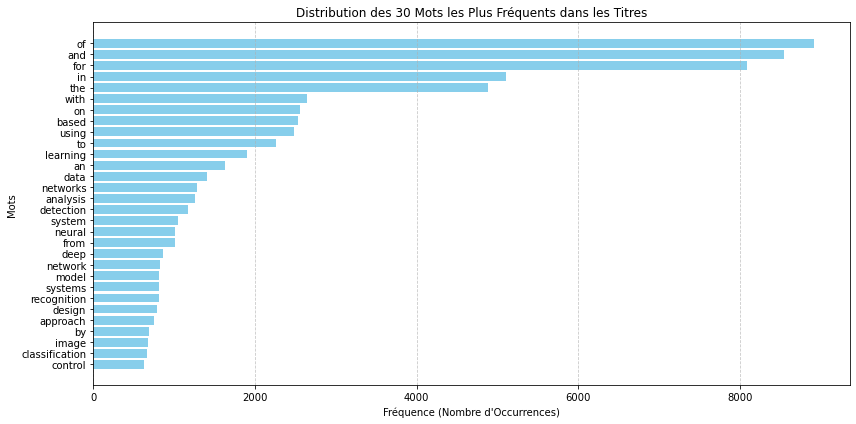

In [16]:
term_frequencies = X_corpus.sum(axis=0).A.flatten()

freq_df = pd.DataFrame({
    'word': features, 
    'count': term_frequencies
})

top_n_words_df = freq_df.sort_values(by='count', ascending=False).head(30)

print("--- 30 Mots les Plus Fréquents dans le Corpus (basé sur les titres) ---")
display(top_n_words_df)

plt.figure(figsize=(12, 6))

plt.barh(top_n_words_df['word'], top_n_words_df['count'], color='skyblue')

plt.gca().invert_yaxis()

plt.title('Distribution des 30 Mots les Plus Fréquents dans les Titres')
plt.xlabel('Fréquence (Nombre d\'Occurrences)')
plt.ylabel('Mots')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 3. Comparaison de documents et premier moteur de recherche

Une manière classique de comparer des vecteurs creux (ce qui est le cas pour la matrice Documents x Termes) est d'utiliser la mesure du cosinus. Celle-ci calcule une **similarité entre deux textes** basée sur les mots en commun.

En utilisant la fonction *cosine_similarity* de la *librairie sklearn*, testez cette mesure sur différentes paires de texte. Vous pouvez également travailler avec les résumés des articles. N'hésitez pas à afficher les documents pour observer les mots qu'ils ont en commun.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

corpus_ids = list(corpus.keys())
corpus_titles = [doc.get('title', '') for doc in corpus.values()]

idx_a = 5
idx_b = 6

idx_c = len(corpus_ids) - 1

doc_a_id = corpus_ids[idx_a]
doc_b_id = corpus_ids[idx_b]
doc_c_id = corpus_ids[idx_c]

vec_a = X_corpus[idx_a]
vec_b = X_corpus[idx_b]
vec_c = X_corpus[idx_c]

similarity_ab = cosine_similarity(vec_a, vec_b)[0][0]

similarity_ac = cosine_similarity(vec_a, vec_c)[0][0]

print(f"--- Similarité Cosinus ---")
print(f"Similarité entre Doc A et Doc B : {similarity_ab:.4f}")
print(f"Similarité entre Doc A et Doc C : {similarity_ac:.4f}")
print("-" * 35)

print(f"\nDocument A (ID: {doc_a_id}) : {corpus_titles[idx_a]}")
print(f"Document B (ID: {doc_b_id}) : {corpus_titles[idx_b]}")
print(f"Document C (ID: {doc_c_id}) : {corpus_titles[idx_c]}")

print("\n--- Analyse des Mots Partagés ---")

df_a = print_feats(vec_a, features, top_n=5)
df_a.rename(columns={'value': 'Count (A)'}, inplace=True)

df_b = print_feats(vec_b, features, top_n=5)
df_b.rename(columns={'value': 'Count (B)'}, inplace=True)

df_c = print_feats(vec_c, features, top_n=5)
df_c.rename(columns={'value': 'Count (C)'}, inplace=True)

display_side_by_side([df_a, df_b, df_c], 
                     [f"Mots de Doc A (Score {similarity_ab:.2f} avec B)", 
                      f"Mots de Doc B", 
                      f"Mots de Doc C (Score {similarity_ac:.2f} avec A)"])

--- Similarité Cosinus ---
Similarité entre Doc A et Doc B : 0.0000
Similarité entre Doc A et Doc C : 0.0000
-----------------------------------

Document A (ID: 857a8c6c46b0a85ed6019f5830294872f2f1dcf5) : Separate face and body selectivity on the fusiform gyrus.
Document B (ID: 12f107016fd3d062dff88a00d6b0f5f81f00522d) : Scheduling for Reduced CPU Energy
Document C (ID: dec997b20ebe2b867f68cc5c123d9cb9eafad6bb) : Deriving optimal weights in deep neural networks

--- Analyse des Mots Partagés ---


,word,Count (A)
0,and,1
1,body,1
2,face,1
3,fusiform,1
4,gyrus,1
,word,Count (B)
0,cpu,1
1,energy,1
2,for,1
3,reduced,1


Vous pouvez à présent écrire un **petit moteur de recherche** qui prend un ensemble de mots clefs, calcule un score pour chaque document de la base et retourne les 10 premieres résultats.

Pour cela, les différentes étapes sont les suivantes :

1. Construire le vecteur requête à partir du texte
1. Calculer le score (cosinus) entre la requête et tous les documents du corpus
1. Triez les résultats et affichez les 10 premiers articles

Pour la première étape, vous pouvez utiliser directement le "vectoriseur" pour construire le vecteur requête dans le même espace de vocabulaire que le corpus (fonction *transform*).

In [ ]:
# TODO

Pour en finir avec cette approche classique "creuse", vous pouvez essayer des variantes :

- Modifier les paramètres du "vectoriseur" : taille du vocabulaire, suppression des mots-outils, suppression des mots trop rares ou trop fréquents, stemming
- Utiliser une autre pondération, comme **TFxIDF**

## 4. Utiliser un meilleur encodeur de documents

L'encodage dans un espace de mots avec TF ou TFxIDF a de nombreuses limites. On utilise aujourd'hui des encodeurs spécialisés pour construire des **représentations denses** beaucoup plus adaptées (cf. cours).

La librairie [sentence-transformers](https://www.sbert.net) propose de très nombreux modèles près à l'emploi. Vous pouvez en choisir un par défaut (comme all-MiniLM-L6-v2, qui est assez rapide et permet d'obtenir des bonnes performances) ou vous laisser guider par les tests réalisés sur le benchmark [MTEB](https://huggingface.co/spaces/mteb/leaderboard).

Attention, suivant la puissance de votre machine (et la présence ou non d'un GPU), l'encodage peut prendre un certain temps. Nous vous conseillons de ne faire le calcul qu'**une seule fois** sur l'ensemble de votre corpus et de stocker les représentations (embeddings) ainsi construit dans un fichier.

Une alternative consiste à construire un index efficace via un **vector store** tel que [FAISS](https://faiss.ai/index.html).

In [ ]:
# TODO : construction des embeddings avec un sentence-transformer

# TODO : sauvegarde des embeddings dans un fichier pour réutilisation ultérieure

Cette partie permet de charger les embeddings en mémoire s'ils ont déjà été stockés dans un fichier.

In [ ]:
# TODO : charger les embeddings depuis un fichier si déjà existant

## 5. Nouveau moteur de recherche

A présent, l'objectif est double :

1. Implémenter un **moteur de recherche**, mais cette fois en vous basant sur les représentations denses construites à l'étape précédente.
2. **Evaluer** la pertinence de votre moteur grâce aux annotations fournies dans le fichier *valid.tsv* qui portent sur les requêtes de *query.tsv* : pour une requête donnée, votre système doit retourner préférentiellement les articles pertinents (score noté 1) en comparaison des articles non pertinents (score noté 0).

Commencez par implémenter le moteur de recherche proprement dit : à partir d'une requête, le système doit trier les 25 documents candidats fournis.

In [ ]:
# TODO

Prenez quelques requêtes en exemple et affichez le résultat de votre moteur. On doit pouvoir vérifier si les 5 premiers résultats sont bien pertinents (score de 1).

In [ ]:
# TODO

A présent, faites tourner le moteur de recherche sur l'ensemble des requêtes du fichier et calculez des indicateurs de qualité.

Il s'agit à minima de :
- précision
- rappel
- f-mesure
- AUC

In [ ]:
# TODO

## 6. Intermède : exploration avec des modèles thématiques

Cette partie est purement exploratoire. Elle consiste à tester au moins un algorithme d'extraction de thématique, tel que LDA. N'hésitez pas à vous référer au notebook associés au cours sur cette partie.

Rien ne vous empêche de tester d'autres algorithmes, parmi lesquels ceux cités durant le cours.

In [ ]:
# TODO

## 7. Construction du graphe de citations

A présent, l'objectif est de construire le graphe de citations et de l'utiliser pour essayer d'améliorer les résultats de notre système de recherche d'information.

Utilisez la librairie Networkx pour construire le graphe à partir de vos fichiers de données. N'hésitez pas à vous référer au notebook fourni associés au cours.

In [ ]:
# TODO

Calculez des indicateurs élémentaires sur ce graphe, par exemple :

- Nombre de noeuds
- Nombre d'arcs
- Densité du graphe
- Degrés entrants et sortants (moyenne, variance)

In [ ]:
# TODO

Pour finir, calculez des indicateurs de centralité afin de faire ressortir les articles qui semblent les plus influents. Essayez de comparer, même qualitativement, les résultats qui peuvent être différents en fonction de la mesure.

In [ ]:
# TODO

## 8. Construire des meilleures représentations pour les noeuds

L'idée principale consiste à utiliser la structure pour améliorer la représentation vectorielle des noeuds / documents. Le plus simple consiste à utiliser les représentations des voisins directs des noeuds, par ex. via une moyenne qu'il est possible de pondérer.

In [ ]:
# TODO

Une fois ces meilleures représentations calculées, vous pouvez tester si elles permettent d'améliorer les résultats de votre moteur de recherche.

In [1]:
# TODO

## 9. Ce qui est attendu

Dans ce projet, le minimum attendu consiste à développer une solution qui teste au moins 1 méthode pour chacun des trois manières de représenter les données, à savoir :
- une approche creuse
- une approche dense
- une approche qui utilise l'information de structure

Néanmoins, il est fortement conseillé de tester *plusieurs* variantes pour chacune de ces manières. Ainsi, pour l'approche creuse, vous pouvez essayer plusieurs techniques de prétraitement et plusieurs schémas de pondération. Pour l'approche dense, vous pouvez essayer plusieurs encodeurs, utiliser un vector store (comme FAISS).

Un document précisant les **consignes** pour ce projet sera fourni en complément de ce notebook.

## 10. Pour aller plus loin

De nombreux raffinements peuvent être envisagés, parmi lesquels :

- Combinaison des approches creuses et denses
- Utilisation d'approches neuronales pour combiner le texte et la structure (par ex. GCN, GNN)
- Utilisation d'approches neuronales pour améliorer la recherche d'information (par ex. COLBERT)